In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import requests
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import time
import scipy.stats as stats
from feature_engine.imputation import MeanMedianImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from feature_engine.encoding import MeanEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import ReciprocalTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import CountFrequencyEncoder
import statsmodels.api as sm

In [2]:
results = pd.read_csv("./f1db_csv_mod/results_mod.csv")
qualifying = pd.read_csv("./f1db_csv_mod/qualifying_mod.csv")
constructors = pd.read_csv("./f1db_csv_mod/constructors_mod.csv")
races = pd.read_csv("./f1db_csv_mod/races_mod.csv")
circuits = pd.read_csv("./f1db_csv_mod/circuits_mod.csv")
drivers = pd.read_csv("./f1db_csv_mod/drivers_mod.csv")
driver_standings = pd.read_csv("./f1db_csv_mod/driver_standings_mod.csv")
constructor_standings = pd.read_csv("./f1db_csv_mod/constructor_standings_mod.csv")

In [3]:
for i, each in enumerate(races['date']):
    parts = str(each).split("/")
    if parts[0] == 'nan':
        races.loc[i, 'date'] = 'nan'
    else:
        if len(parts[2]) == 5 and parts[2].startswith("1"):
            parts[2] = parts[2][1:]  # Remove extra "1"
        races.loc[i, 'date'] = "/".join(parts)

races["date"] = pd.to_datetime(races["date"], format="%m/%d/%Y")
races['year'] = races['date'].dt.year
df = results.merge(qualifying, on=["raceId", "driverId", "constructorId"], how="left")
df = df.merge(races[["raceId", "circuitId", "year", "round", "date", "time"]], on="raceId", how="left")
df = df.merge(circuits[["circuitId", "alt", "country", "location"]], on="circuitId", how="left")
df = df.merge(constructors[["constructorId", "nationality", "name"]], on="constructorId", how="left")
df = df.merge(drivers[['driverId', 'dob', 'nationality']], on='driverId', how='left')

# Map each (year, round) to the previous round to get pre-race standings
prev_round = races[['raceId','year','round']].assign(prev_round=lambda d: d['round']-1)
prev_round = prev_round.merge(races[['raceId','year','round']].rename(columns={'raceId':'prev_raceId','round':'prev_round'}),
                              on=['year','prev_round'], how='left').drop(columns='prev_round')

# Join prev driver standings (season-to-date BEFORE this race)
ds_prev = driver_standings[['raceId','driverId','position','wins','points']]\
            .rename(columns={'raceId':'prev_raceId','position':'drv_pos_s2d','wins':'drv_wins_s2d', 'points':'drv_pts_s2d'})
df = df.merge(prev_round[['raceId','prev_raceId']], on='raceId', how='left')\
           .merge(ds_prev, on=['prev_raceId','driverId'], how='left')

# Join prev constructor standings
cs_prev = constructor_standings[['raceId','constructorId','position','wins','points']]\
            .rename(columns={'raceId':'prev_raceId','position':'team_pos_s2d','wins':'team_wins_s2d','points':'team_pts_s2d'})
df = df.merge(cs_prev, on=['prev_raceId','constructorId'], how='left')


In [4]:
df['drv_pts_s2d'] = pd.to_numeric(df['drv_pts_s2d'], errors='coerce')
df['month'] = df['date'].dt.month
df['start_hour'] = pd.to_datetime(df['time_y'], format='%H:%M:%S', errors='coerce').dt.hour
df['is_night_race'] = df['start_hour'].apply(lambda x: 1 if x >= 18 else 0)

# Driver average points per circuit
drv_circuit_perf = df.groupby(['driverId', 'circuitId'])['points'].mean().reset_index()
drv_circuit_perf.rename(columns={'points': 'drv_avg_pts_circuit'}, inplace=True)

# Team average points per circuit
team_circuit_perf = df.groupby(['constructorId', 'circuitId'])['points'].mean().reset_index()
team_circuit_perf.rename(columns={'points': 'team_avg_pts_circuit'}, inplace=True)

# Merge into main dataset
df = df.merge(drv_circuit_perf, on=['driverId', 'circuitId'], how='left')\
       .merge(team_circuit_perf, on=['constructorId', 'circuitId'], how='left')

df['drv_pts_momentum'] = df['drv_pts_s2d'] / df['prev_raceId']  # avg pts per race so far
df['team_pts_momentum'] = df['team_pts_s2d'] / df['prev_raceId']
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['driver_age'] = (df['date'] - df['dob']).dt.days // 365
df.drop('dob', axis=1, inplace=True)
df['alt'] = pd.to_numeric(df['alt'], errors='coerce')
df.replace('\\N', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25399 entries, 0 to 25398
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   resultId              25399 non-null  int64         
 1   raceId                25399 non-null  int64         
 2   driverId              25399 non-null  int64         
 3   constructorId         25399 non-null  int64         
 4   number_x              25393 non-null  object        
 5   grid                  25399 non-null  int64         
 6   position_x            14613 non-null  object        
 7   positionText          25399 non-null  object        
 8   positionOrder         25399 non-null  int64         
 9   points                25399 non-null  float64       
 10  laps                  25399 non-null  int64         
 11  time_x                6809 non-null   object        
 12  milliseconds          6808 non-null   object        
 13  fastestLap      

In [5]:
df['constructor_name'] = df['name']
df['constructor_nationality'] = df['nationality_x']
df['circuit_country'] = df['country']
df['driver_nationality'] = df['nationality_y']

In [6]:
df = df.drop(columns=['resultId', 
                      'raceId', 
                      'driverId', 
                      'constructorId',
                      'statusId',
                      'qualifyId',
                      'circuitId',
                      'number_x' ,
                      'position_x', 
                      'positionText', 
                      'positionOrder',
                      'laps',
                      'time_x',
                      'milliseconds',
                      'fastestLap',
                      'fastestLapTime',
                      'fastestLapSpeed',
                      'number_y',
                      'position_y',
                      'q1',
                      'q2',
                      'q3',
                      'date',
                      'time_y',
                      'country',
                      'nationality_x',
                      'name',
                      'nationality_y',
                      'prev_raceId',
                      'rank'
                     ])

# Keep only races from 2011 onwards
df_modern = df[df['year'] >= 2011].copy()

print(f"Original dataset size: {df.shape[0]}")
print(f"Modern era dataset size: {df_modern.shape[0]}")

points_col = df_modern.pop('points')  # Removes and stores the column
df_modern['points'] = points_col
df = df_modern

Original dataset size: 25399
Modern era dataset size: 4476


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 20776 to 25398
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   grid                     4476 non-null   int64  
 1   year                     4476 non-null   float64
 2   round                    4476 non-null   int64  
 3   alt                      4456 non-null   float64
 4   location                 4476 non-null   object 
 5   drv_pos_s2d              4117 non-null   float64
 6   drv_wins_s2d             4117 non-null   float64
 7   drv_pts_s2d              4109 non-null   float64
 8   team_pos_s2d             4134 non-null   float64
 9   team_wins_s2d            4134 non-null   float64
 10  team_pts_s2d             4134 non-null   float64
 11  month                    4476 non-null   float64
 12  start_hour               4476 non-null   float64
 13  is_night_race            4476 non-null   int64  
 14  drv_avg_pts_circuit     

In [8]:
df

,grid,year,round,alt,location,drv_pos_s2d,drv_wins_s2d,drv_pts_s2d,team_pos_s2d,team_wins_s2d,...,drv_avg_pts_circuit,team_avg_pts_circuit,drv_pts_momentum,team_pts_momentum,driver_age,constructor_name,constructor_nationality,circuit_country,driver_nationality,points
20776,1,2011.0,1,10.0,Melbourne,NaN,NaN,NaN,NaN,NaN,...,12.500000,5.433333,NaN,NaN,23.0,Red Bull,Austrian,Australia,German,25.0
20777,2,2011.0,1,10.0,Melbourne,NaN,NaN,NaN,NaN,NaN,...,12.615385,5.104167,NaN,NaN,26.0,McLaren,British,Australia,British,18.0
20778,6,2011.0,1,10.0,Melbourne,NaN,NaN,NaN,NaN,NaN,...,5.000000,3.678571,NaN,NaN,26.0,Renault,French,Australia,Russian,15.0
20779,5,2011.0,1,10.0,Melbourne,NaN,NaN,NaN,NaN,NaN,...,7.187500,7.083333,NaN,NaN,29.0,Ferrari,Italian,Australia,Spanish,12.0
20780,3,2011.0,1,10.0,Melbourne,NaN,NaN,NaN,NaN,NaN,...,3.166667,5.433333,NaN,NaN,34.0,Red Bull,Austrian,Australia,Australian,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25394,4,2021.0,22,3.0,Abu Dhabi,4.0,1.0,190.0,2.0,10.0,...,4.000000,11.769231,0.177239,0.521922,31.0,Red Bull,Austrian,UAE,Mexican,0.0
25395,16,2021.0,22,3.0,Abu Dhabi,17.0,0.0,7.0,8.0,0.0,...,0.000000,3.346154,0.006530,0.021455,26.0,Williams,British,UAE,Canadian,0.0
25396,14,2021.0,22,3.0,Abu Dhabi,18.0,0.0,3.0,9.0,0.0,...,0.000000,0.000000,0.002799,0.012127,28.0,Alfa Romeo,Swiss,UAE,Italian,0.0
25397,17,2021.0,22,3.0,Abu Dhabi,15.0,0.0,16.0,8.0,0.0,...,0.000000,3.346154,0.014925,0.021455,23.0,Williams,British,UAE,British,0.0


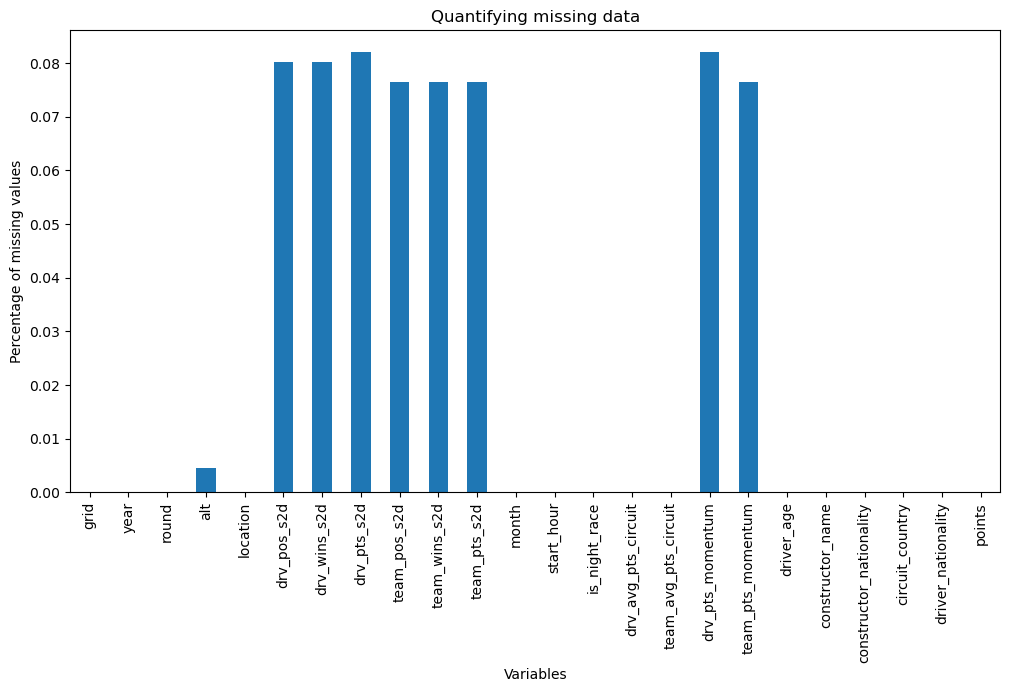

grid                         0
year                         0
round                        0
alt                         20
location                     0
drv_pos_s2d                359
drv_wins_s2d               359
drv_pts_s2d                367
team_pos_s2d               342
team_wins_s2d              342
team_pts_s2d               342
month                        0
start_hour                   0
is_night_race                0
drv_avg_pts_circuit          0
team_avg_pts_circuit         0
drv_pts_momentum           367
team_pts_momentum          342
driver_age                   0
constructor_name             0
constructor_nationality      0
circuit_country              0
driver_nationality           0
points                       0
dtype: int64


In [9]:
#Checking for missing values
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')
plt.show()
print(df.isnull().sum())

### Data Cleaning & Transformation

In [11]:
y = df["points"]
df = df.drop(columns=['points'])
X = df.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

X_train.shape, X_test.shape

((3580, 23), (896, 23))

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3580 entries, 23360 to 24732
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   grid                     3580 non-null   int64  
 1   year                     3580 non-null   float64
 2   round                    3580 non-null   int64  
 3   alt                      3563 non-null   float64
 4   location                 3580 non-null   object 
 5   drv_pos_s2d              3302 non-null   float64
 6   drv_wins_s2d             3302 non-null   float64
 7   drv_pts_s2d              3296 non-null   float64
 8   team_pos_s2d             3313 non-null   float64
 9   team_wins_s2d            3313 non-null   float64
 10  team_pts_s2d             3313 non-null   float64
 11  month                    3580 non-null   float64
 12  start_hour               3580 non-null   float64
 13  is_night_race            3580 non-null   int64  
 14  drv_avg_pts_circuit     

In [13]:
cat_cols = [c for c in X_train.columns if X_train[c].dtypes=='O']
num_cols = [c for c in X_train.columns if X_train[c].dtypes!='O']

#### Filling in Missing Values

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_median_cols = ['alt']
num_zero_cols = ['drv_wins_s2d', 'team_wins_s2d', 'drv_pts_momentum', 'team_pts_momentum', 'drv_pts_s2d', 'team_pts_s2d']
ordinal_cols = ['drv_pos_s2d', 'team_pos_s2d']


num_median_imputer = Pipeline([('imputer', SimpleImputer(strategy='median'))])
num_zero_imputer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0))])
ordinal_imputer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))])


preprocessor = ColumnTransformer([
    ('num_median', num_median_imputer, num_median_cols),
    ('num_zero', num_zero_imputer, num_zero_cols),
    ('ordinal', ordinal_imputer, ordinal_cols),
], remainder='passthrough')

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

imputed_cols = num_median_cols + num_zero_cols + ordinal_cols 

# 2. Columns that were passed through (remainder='passthrough')
pass_through_cols = [col for col in X_train.columns if col not in imputed_cols]

# 3. Combine them
final_cols = imputed_cols + pass_through_cols

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_transformed, columns=final_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=final_cols, index=X_test.index)
for each in num_cols:
    X_train[each] = pd.to_numeric(X_train[each], errors='coerce')
    X_test[each] = pd.to_numeric(X_test[each], errors='coerce')

print(X_train.head())

         alt  drv_wins_s2d  team_wins_s2d  drv_pts_momentum  \
23360    3.0           0.0            0.0          0.052740   
21848   13.0           0.0            2.0          0.050847   
23621  162.0           0.0            4.0          0.130612   
24773  162.0           0.0            0.0          0.000000   
21359    7.0           0.0            0.0          0.025463   

       team_pts_momentum  drv_pts_s2d  team_pts_s2d  drv_pos_s2d  \
23360           0.140641         51.0         136.0         11.0   
21848           0.138983         45.0         123.0          7.0   
23621           0.355102        128.0         348.0          5.0   
24773           0.000000          0.0           0.0         20.0   
21359           0.047454         22.0          41.0         10.0   

       team_pos_s2d  grid  ...  month  start_hour is_night_race  \
23360           5.0    10  ...   11.0        13.0             0   
21848           2.0    16  ...    6.0        18.0             1   
23621      

In [16]:
print("****X_train****")
print(X_train.isnull().sum())
print("****X_test****")
print(X_test.isnull().sum())

****X_train****
alt                        0
drv_wins_s2d               0
team_wins_s2d              0
drv_pts_momentum           0
team_pts_momentum          0
drv_pts_s2d                0
team_pts_s2d               0
drv_pos_s2d                0
team_pos_s2d               0
grid                       0
year                       0
round                      0
location                   0
month                      0
start_hour                 0
is_night_race              0
drv_avg_pts_circuit        0
team_avg_pts_circuit       0
driver_age                 0
constructor_name           0
constructor_nationality    0
circuit_country            0
driver_nationality         0
dtype: int64
****X_test****
alt                        0
drv_wins_s2d               0
team_wins_s2d              0
drv_pts_momentum           0
team_pts_momentum          0
drv_pts_s2d                0
team_pts_s2d               0
drv_pos_s2d                0
team_pos_s2d               0
grid                       0

### Dealing With Numerical Columns

grid


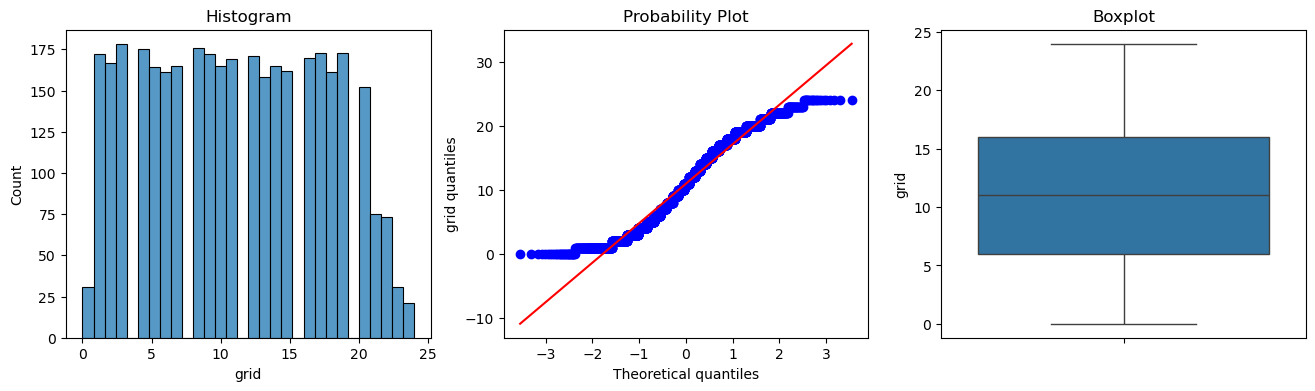

year


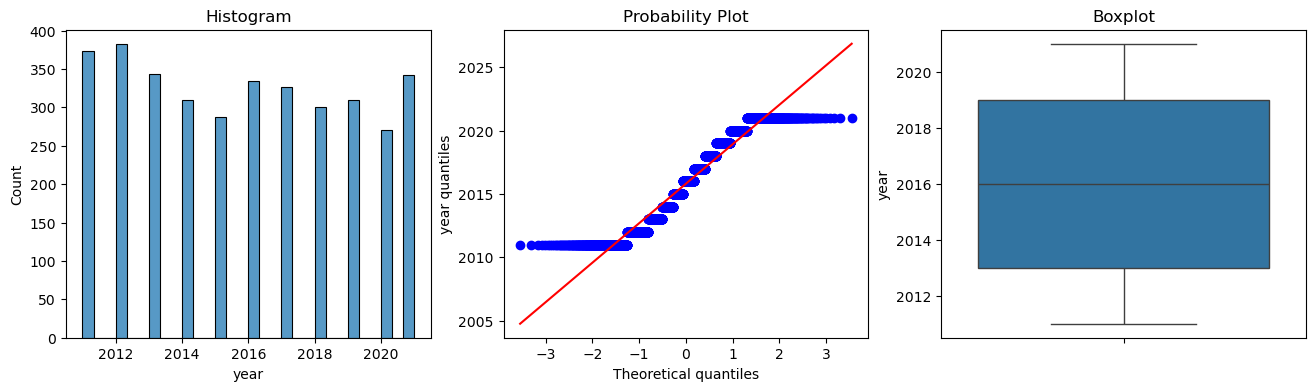

round


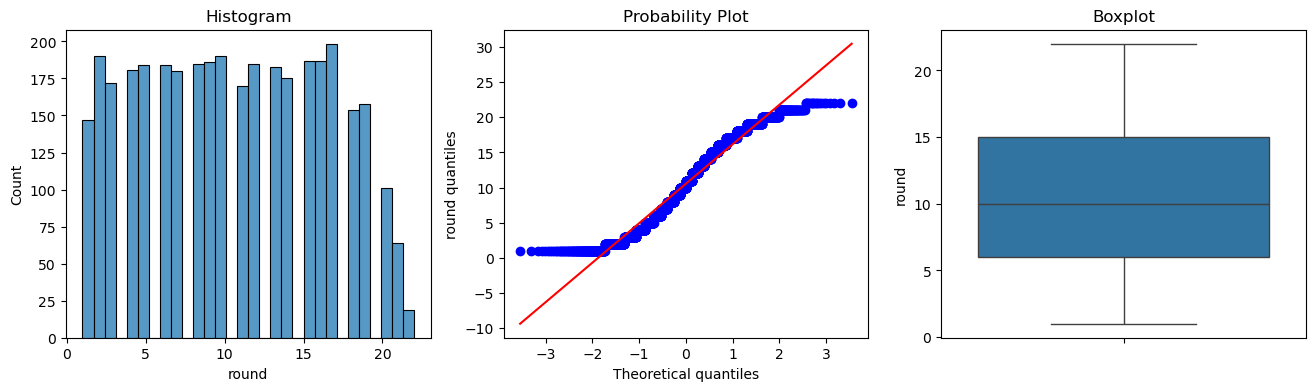

alt


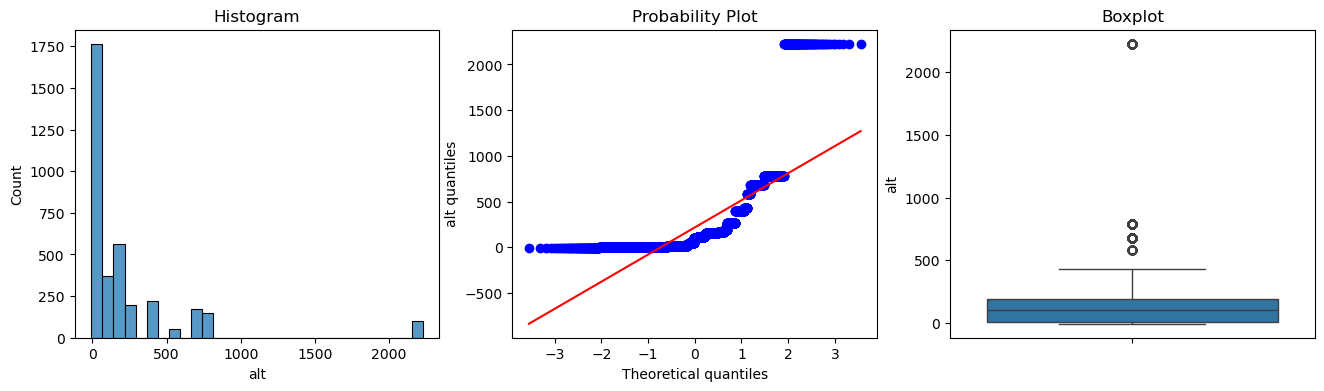

drv_pos_s2d


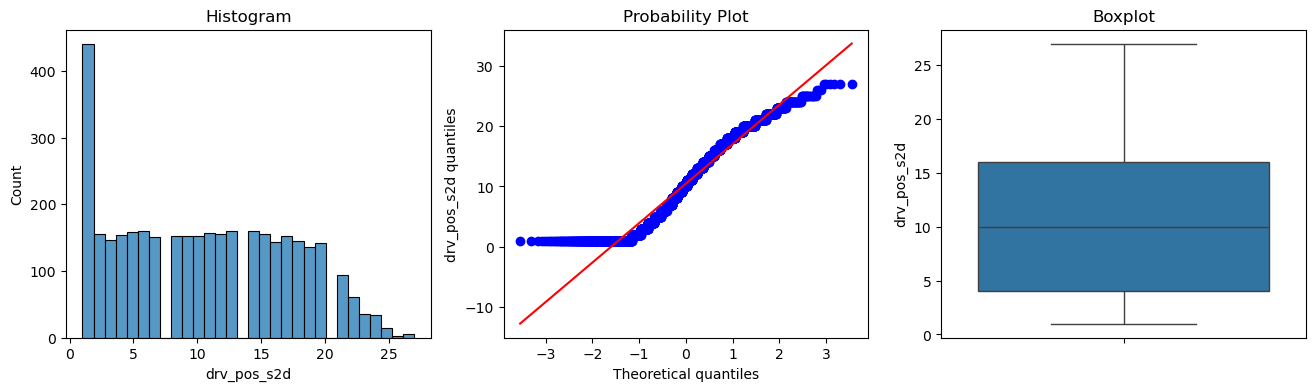

drv_wins_s2d


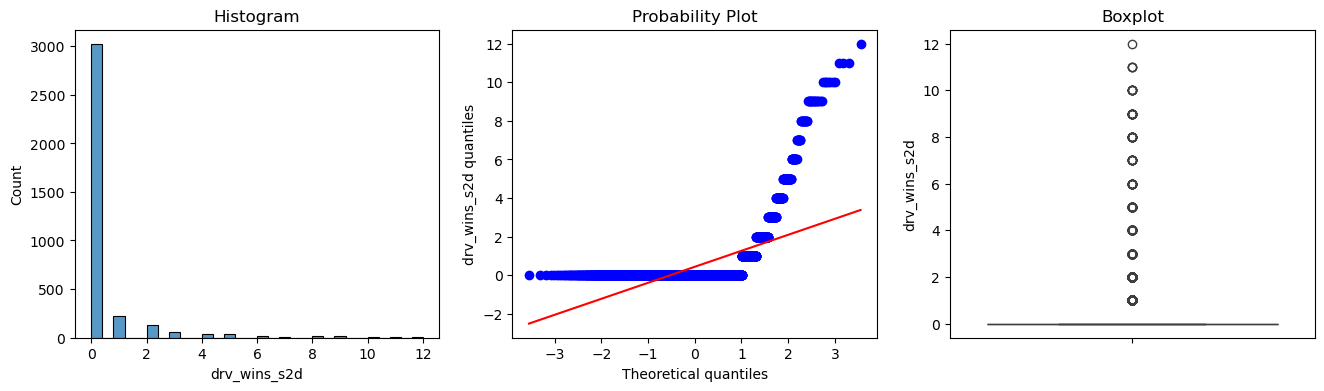

drv_pts_s2d


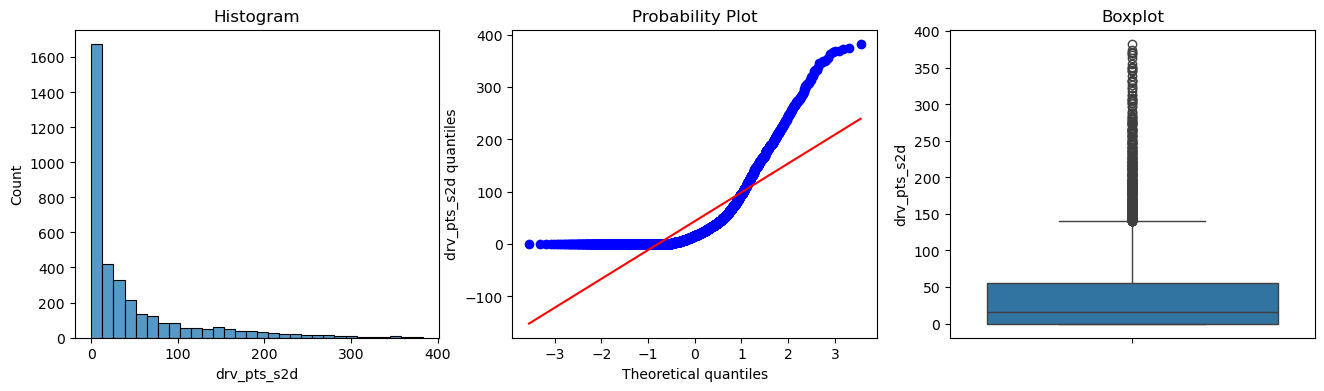

team_pos_s2d


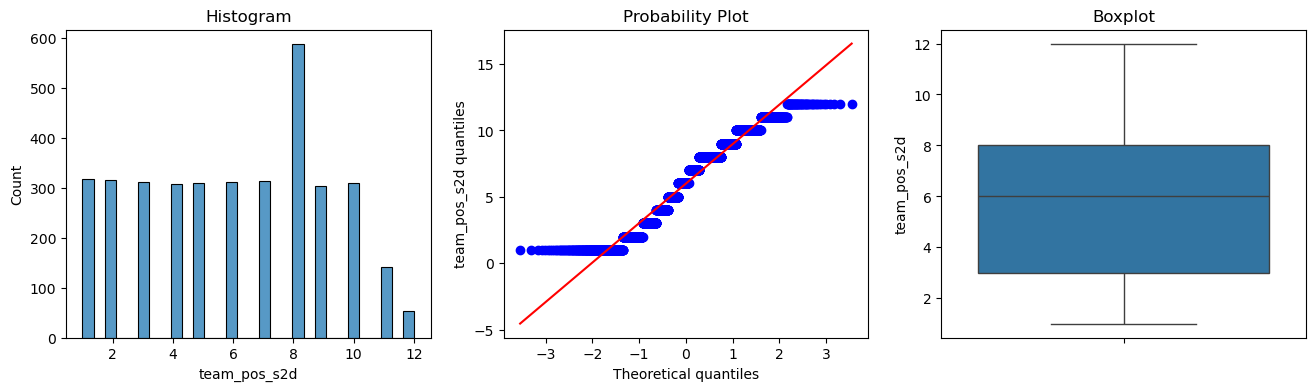

team_wins_s2d


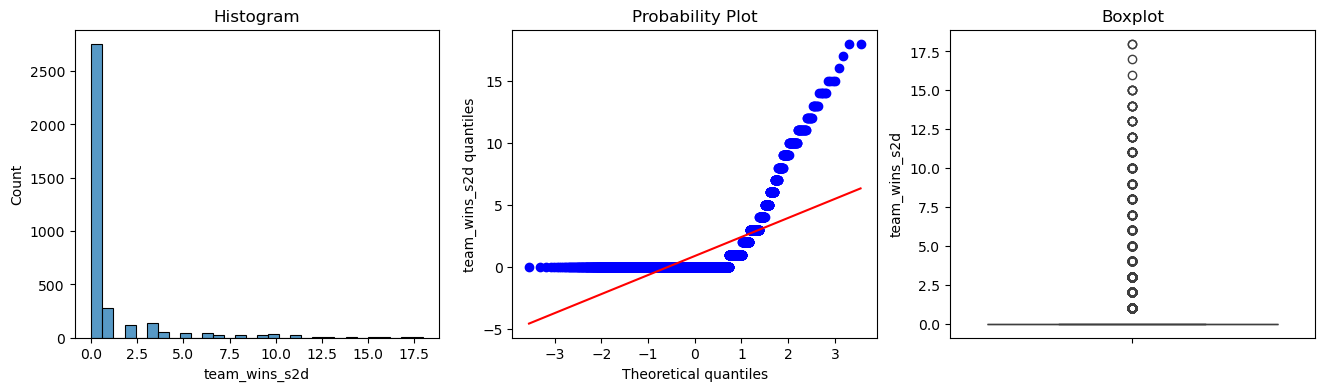

team_pts_s2d


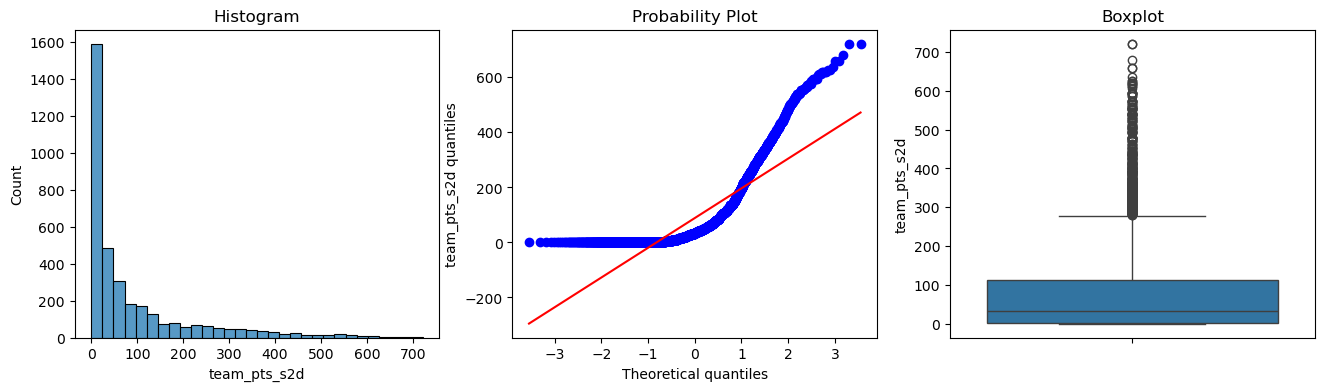

month


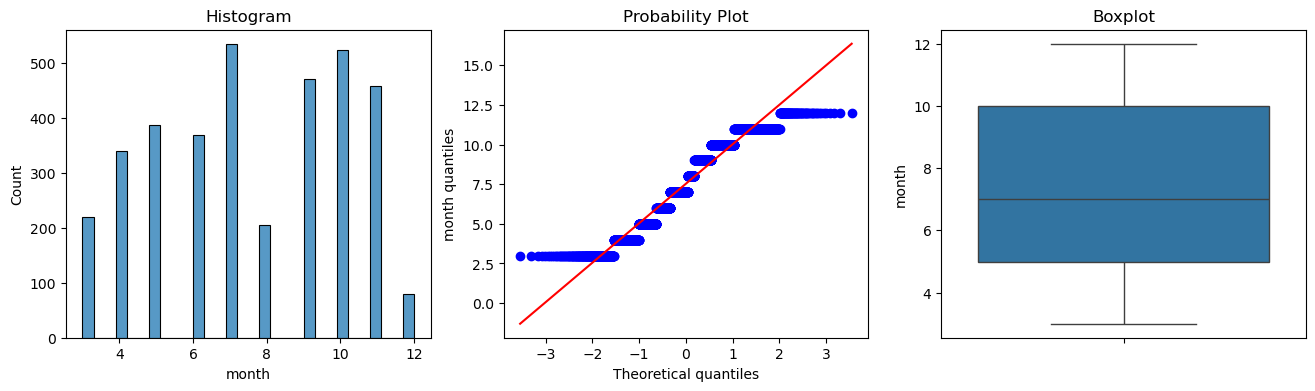

start_hour


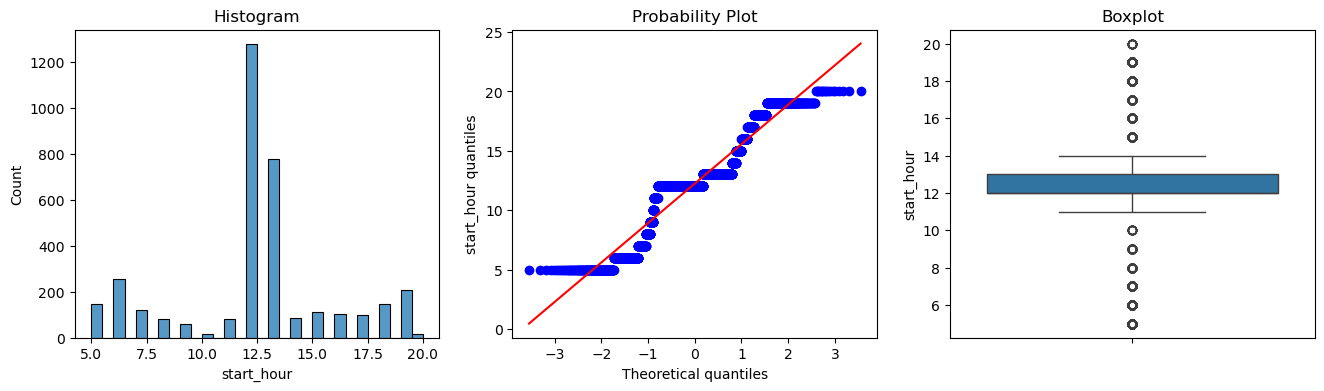

is_night_race


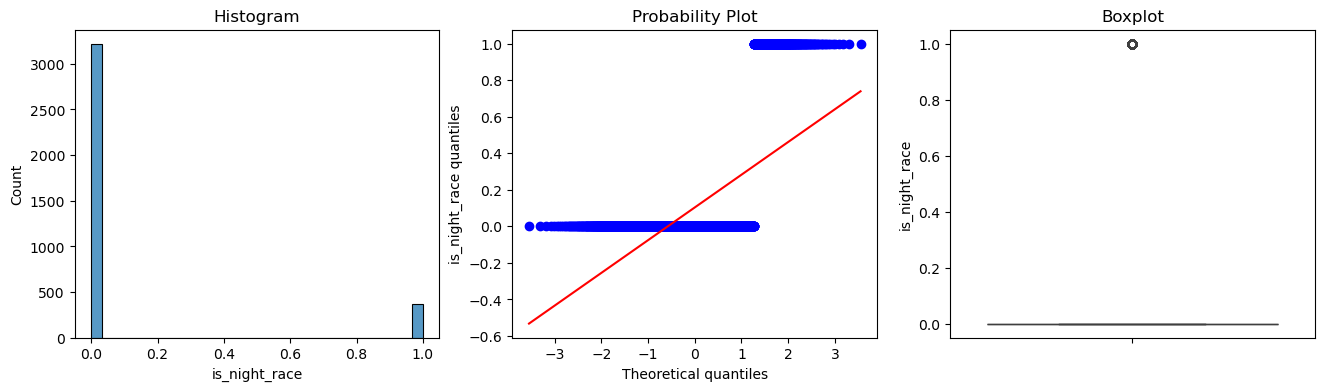

drv_avg_pts_circuit


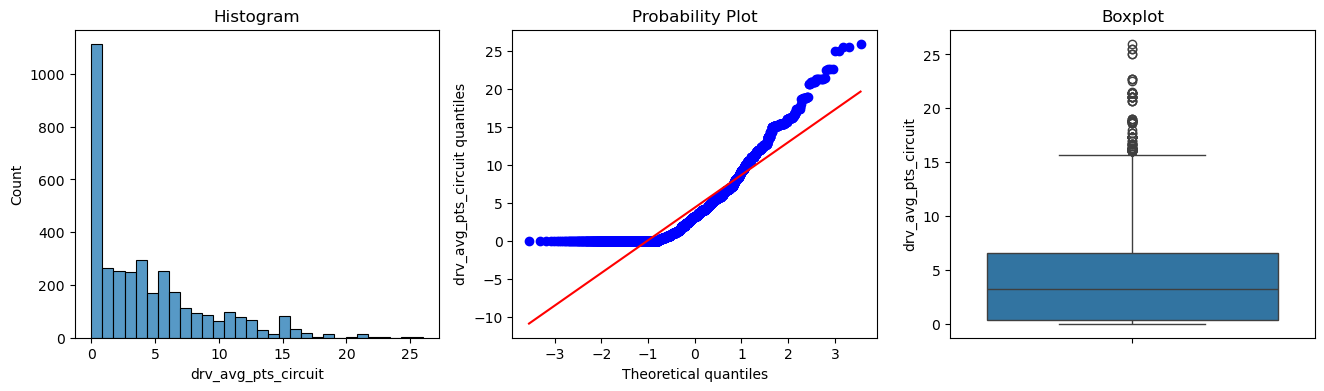

team_avg_pts_circuit


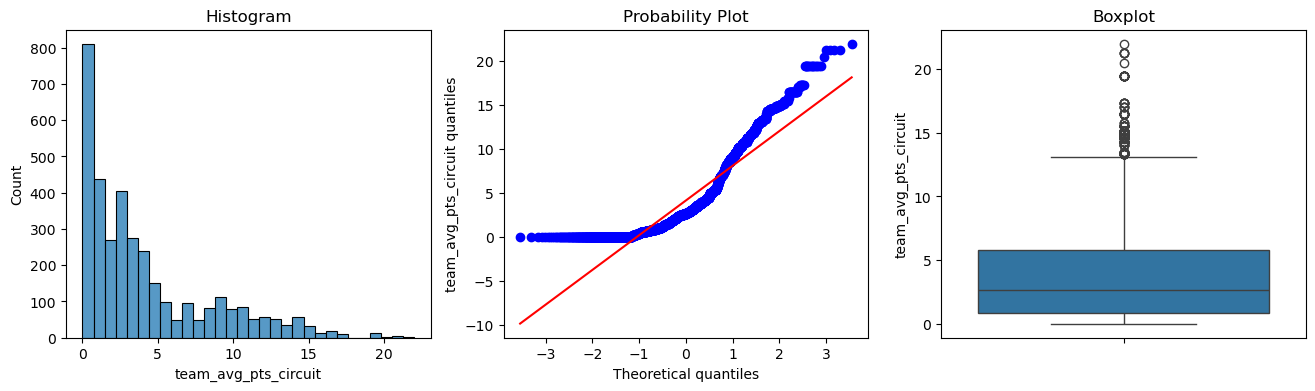

drv_pts_momentum


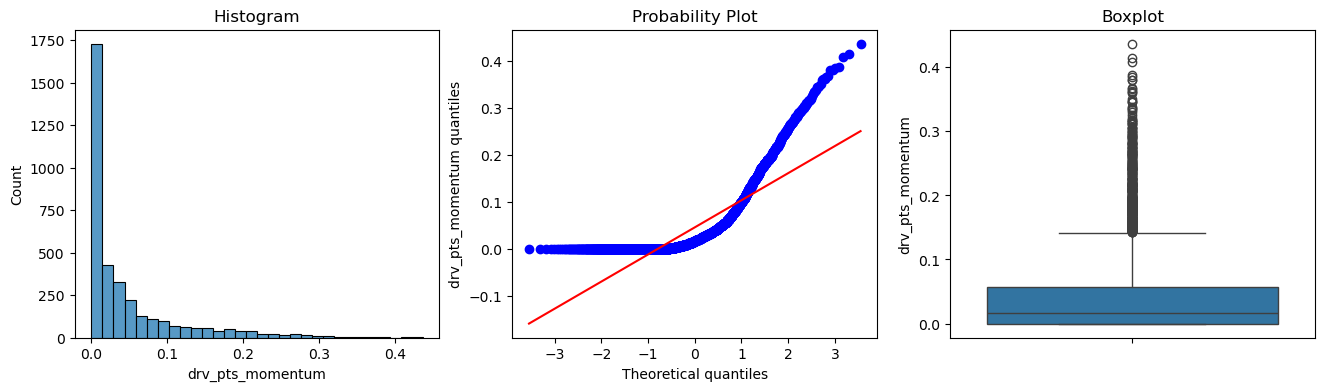

team_pts_momentum


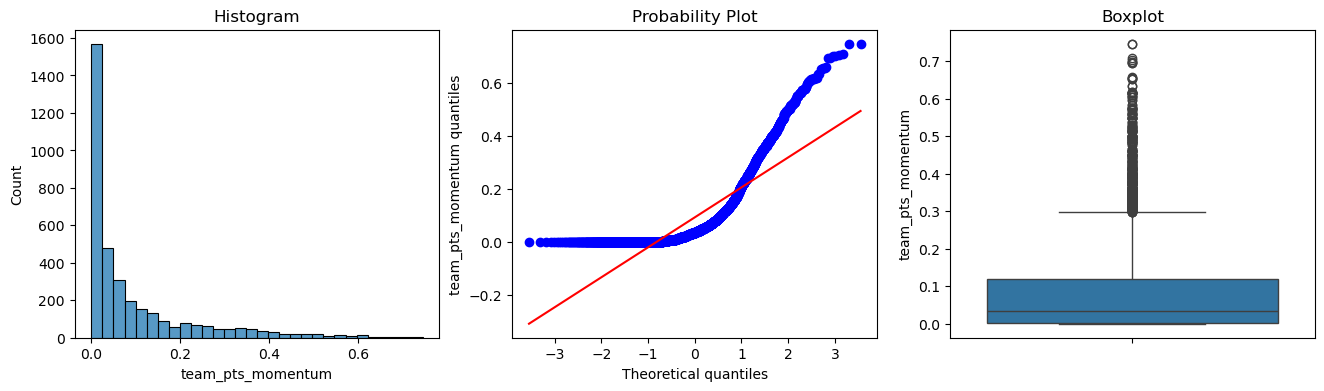

driver_age


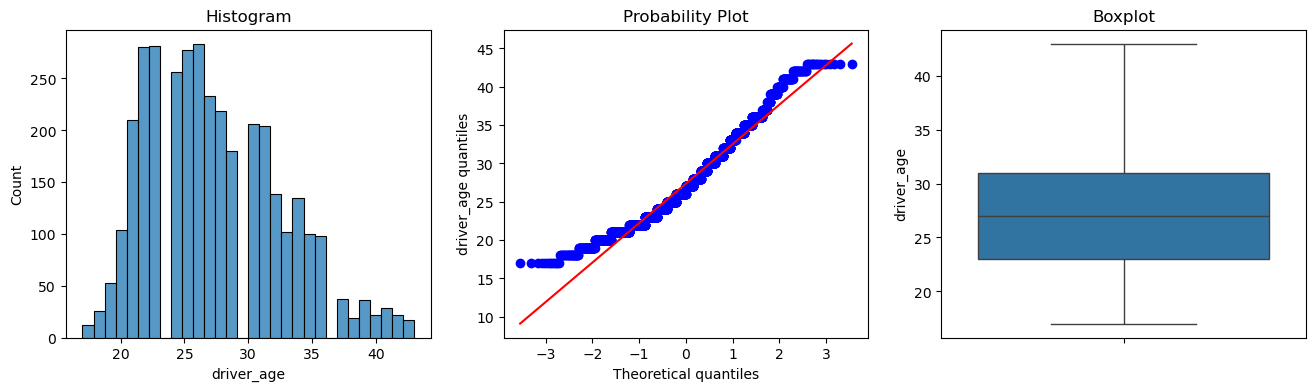

In [18]:
def diagnostic_plots(df, variable):
    
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(f'{variable} quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

for each in num_cols:
    print(each)
    diagnostic_plots(X_train, each)

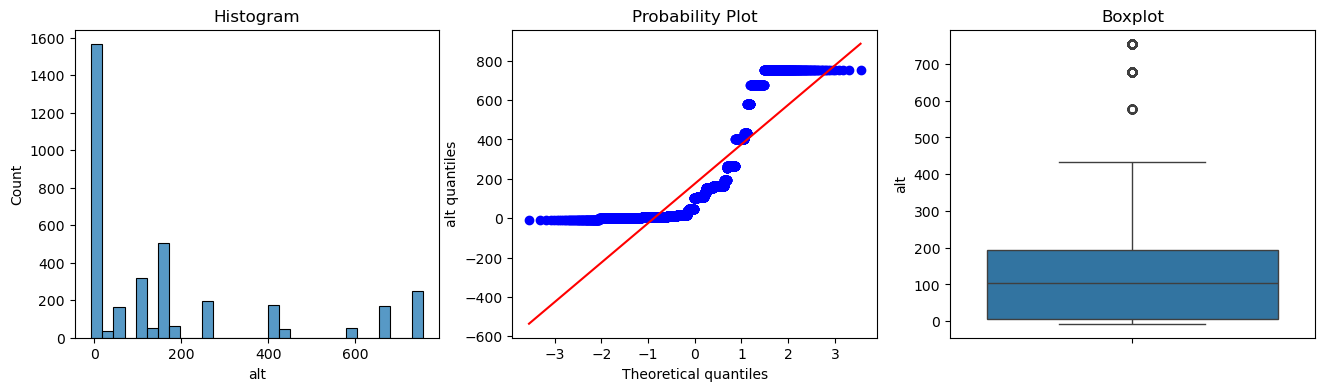

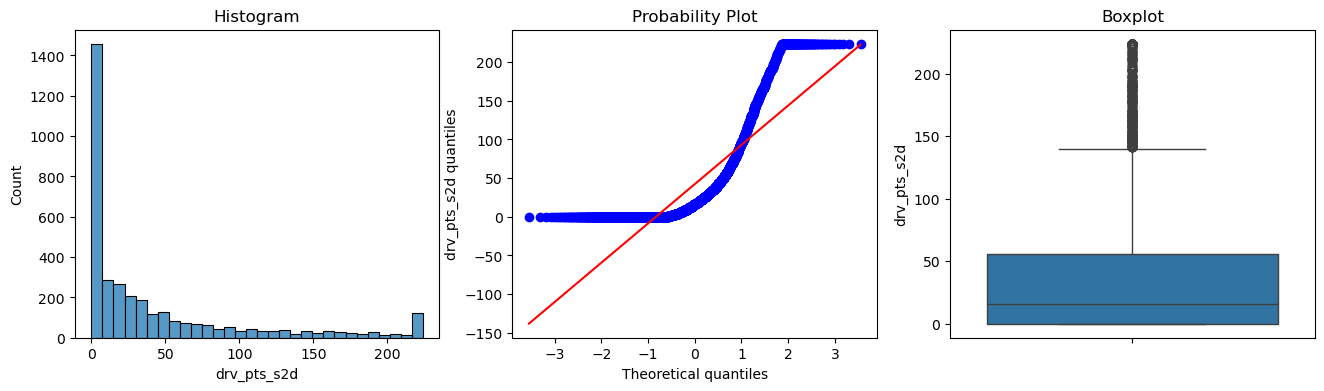

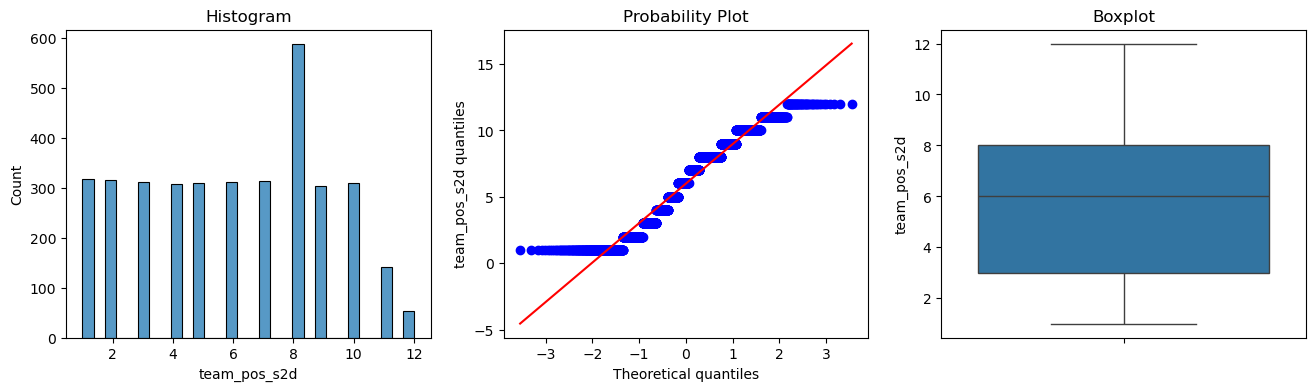

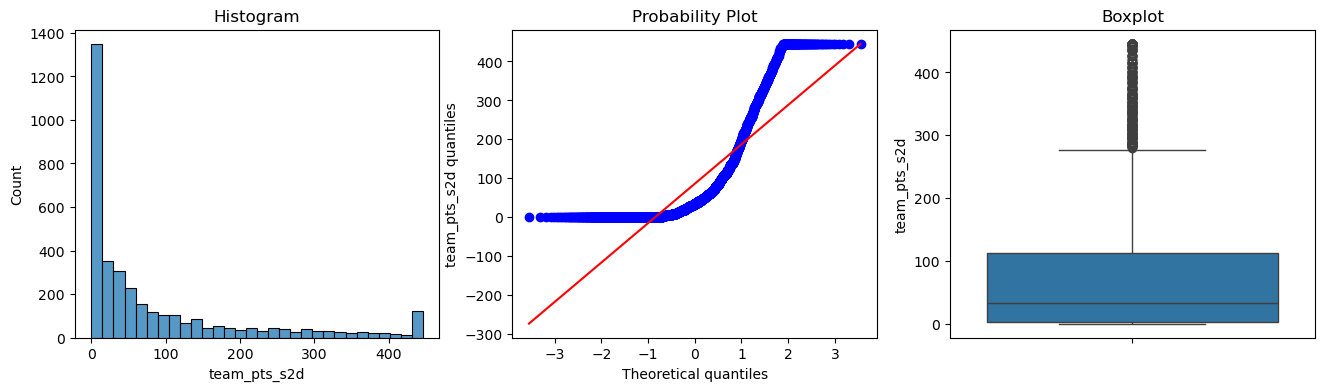

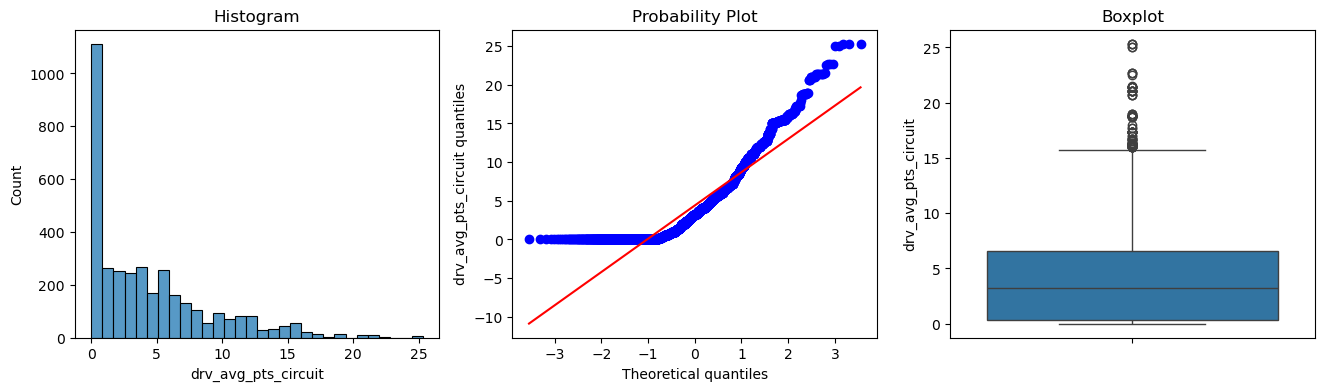

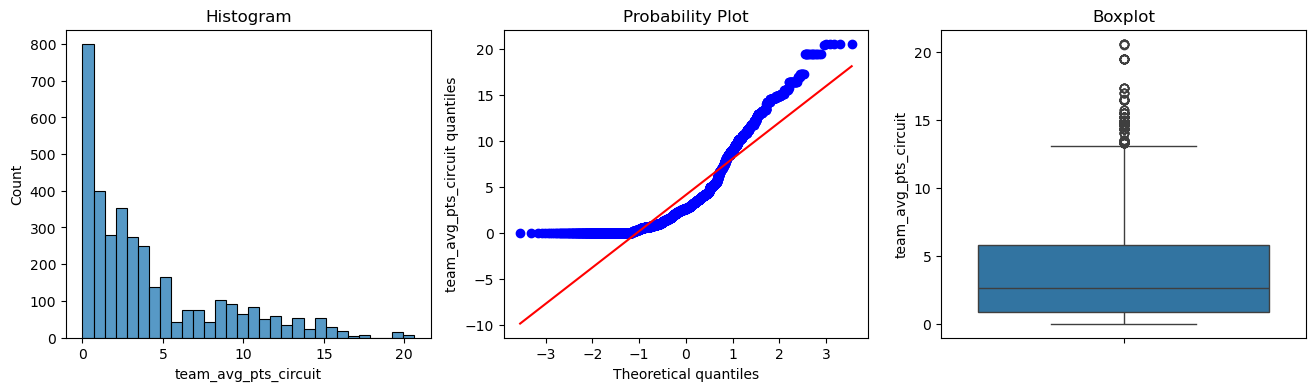

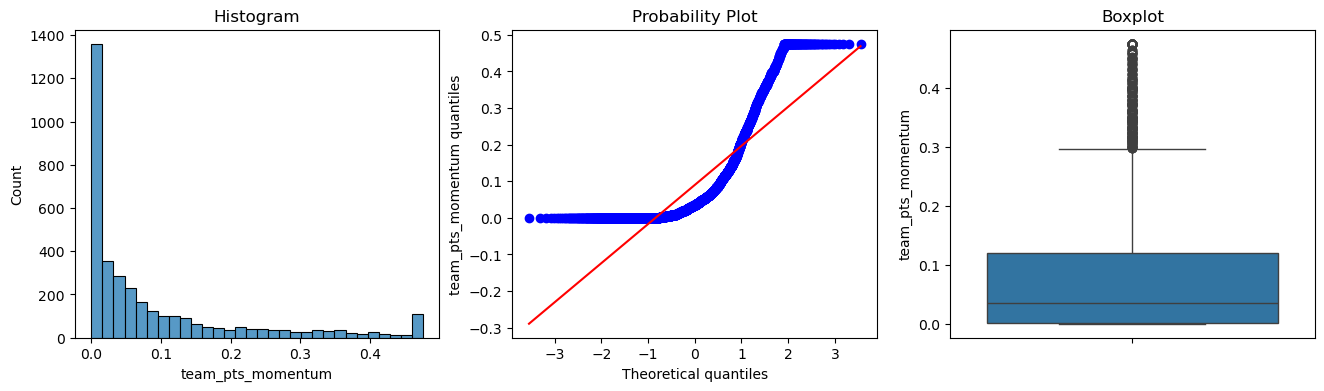

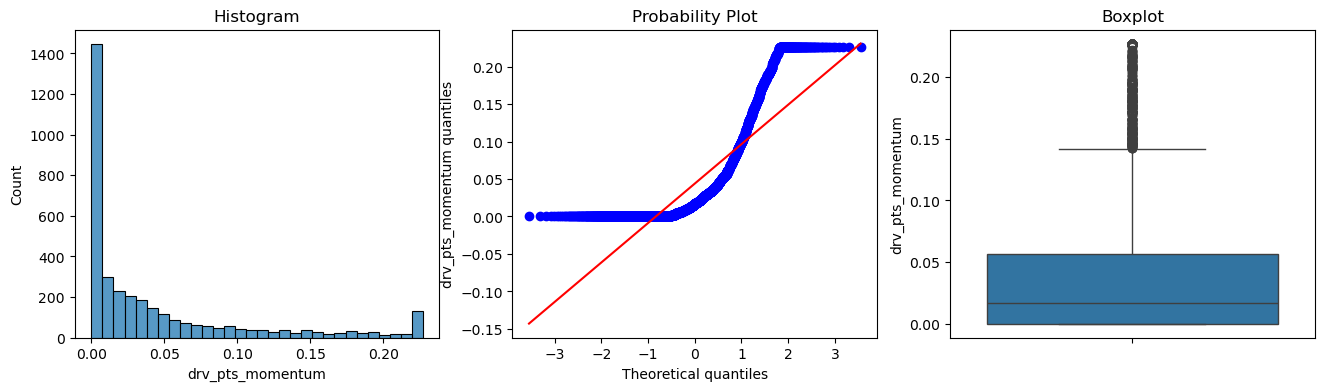

In [19]:
outliers = [
    'alt',
    'drv_pts_s2d',
    'team_pos_s2d',
    'team_pts_s2d',
    'drv_avg_pts_circuit',
    'team_avg_pts_circuit',
    'team_pts_momentum', 
    'drv_pts_momentum'
]
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='right', # cap left, right or both tails 
                          fold=3,
                          variables=outliers)

windsorizer.fit(X_train)

X_train = windsorizer.transform(X_train)
X_test = windsorizer.transform(X_test)
for each in outliers:
    diagnostic_plots(X_train, each)

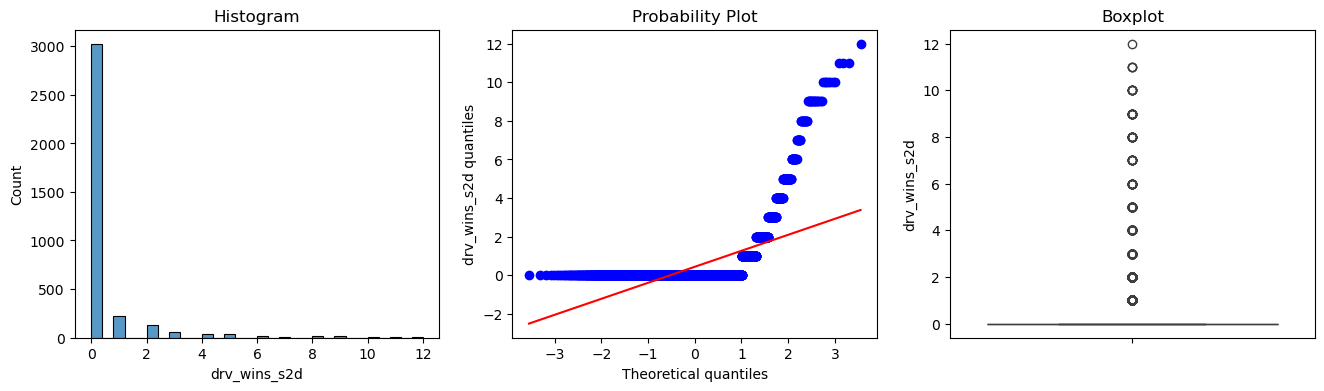

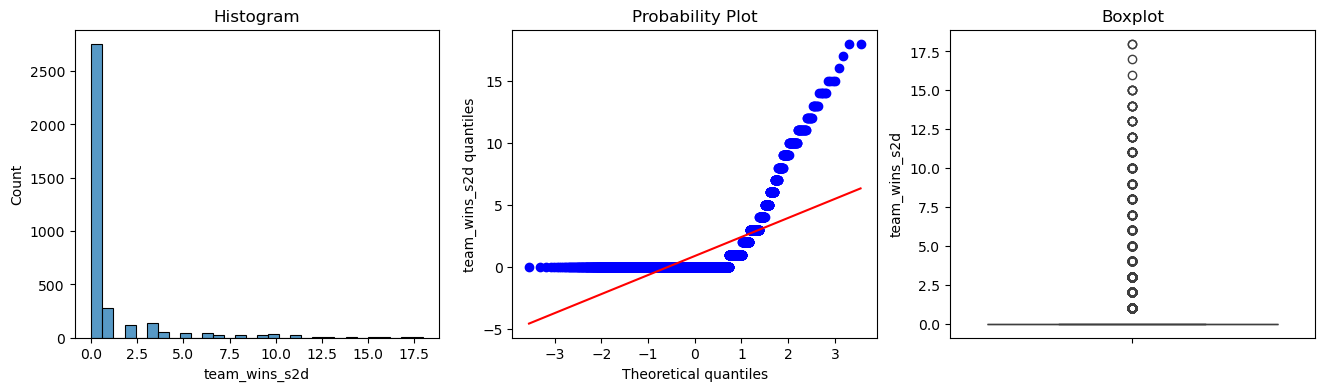

In [20]:
winsorizer = Winsorizer(
    capping_method='gaussian',
    tail='both',
    fold=3, 
    variables=['drv_wins_s2d', 'team_wins_s2d']
)

windsorizer.fit(X_train)
X_train = windsorizer.transform(X_train)
X_test = windsorizer.transform(X_test)
diagnostic_plots(X_train, 'drv_wins_s2d')
diagnostic_plots(X_train, 'team_wins_s2d')

alt


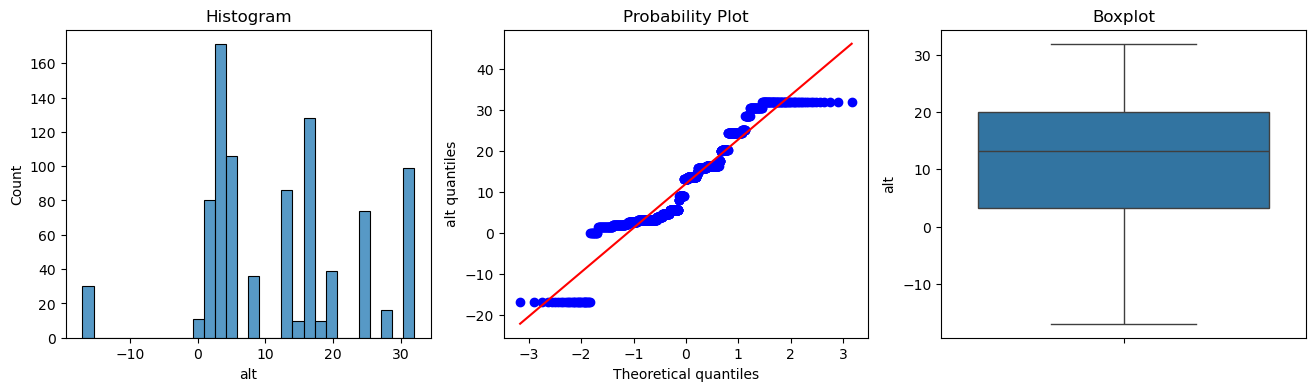

driver_age


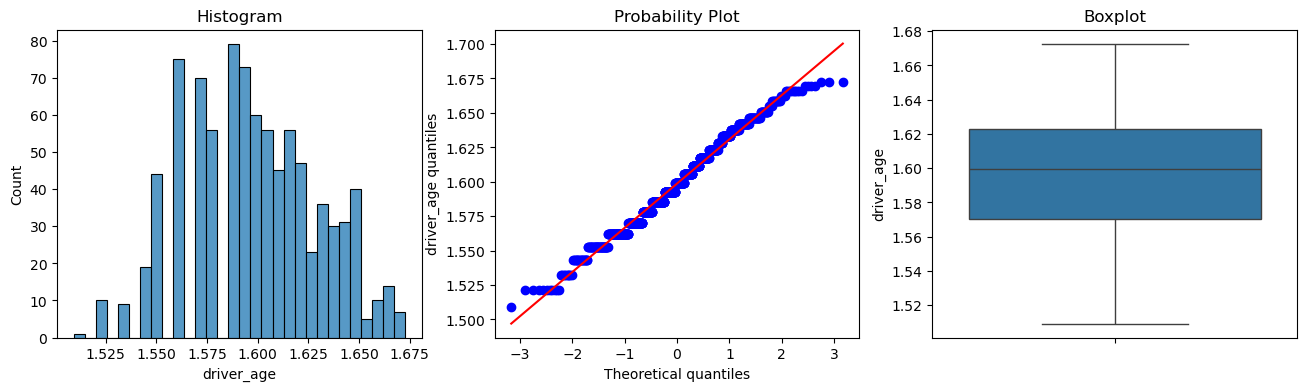

In [21]:
X_train_yjt = X_train.copy()
X_test_yjt = X_test.copy()
skewed = [
    'alt',
    'driver_age',   
]

skewed_train = [f for f in skewed if f in X_train_yjt.columns]
skewed_test = [f for f in skewed if f in X_test_yjt.columns]
yjt = YeoJohnsonTransformer(variables = skewed_train)
X_train_yjt[skewed_train] = yjt.fit_transform(X_train_yjt[skewed_train])
yjt = YeoJohnsonTransformer(variables = skewed_train)
X_test_yjt[skewed_train] = yjt.fit_transform(X_test_yjt[skewed_train])
for each in skewed_train:
    print(each)
    diagnostic_plots(X_test_yjt, each)

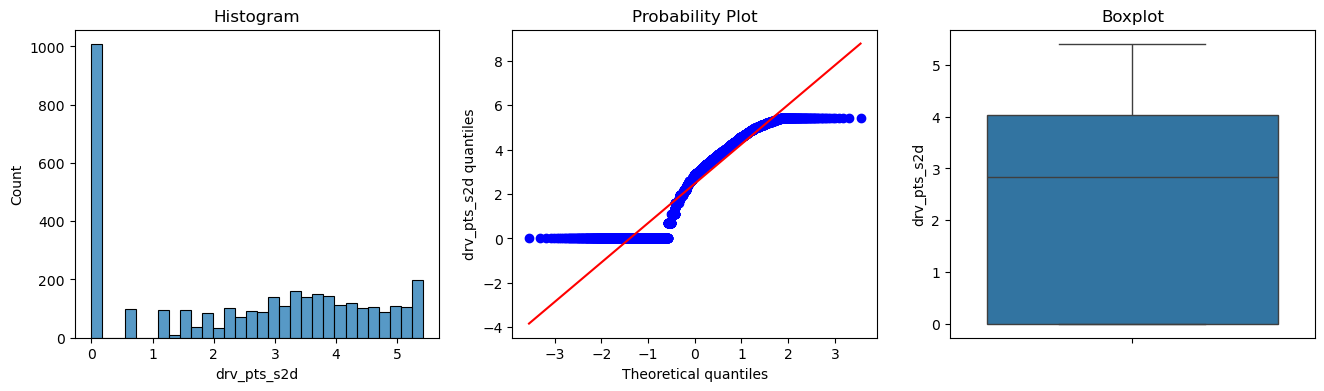

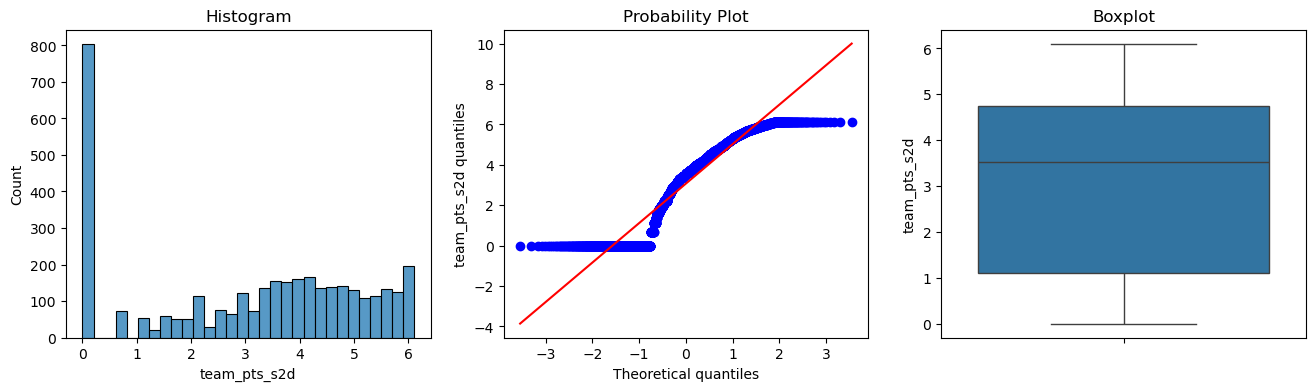

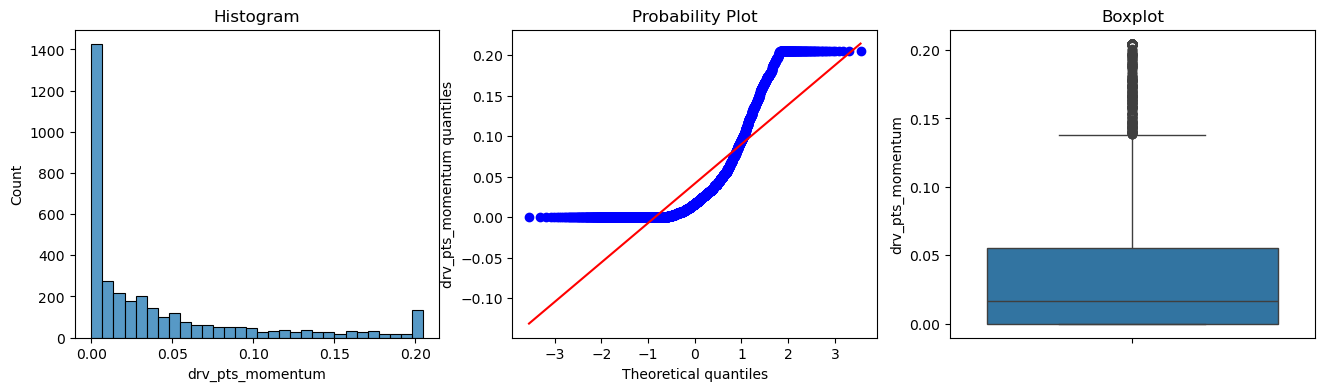

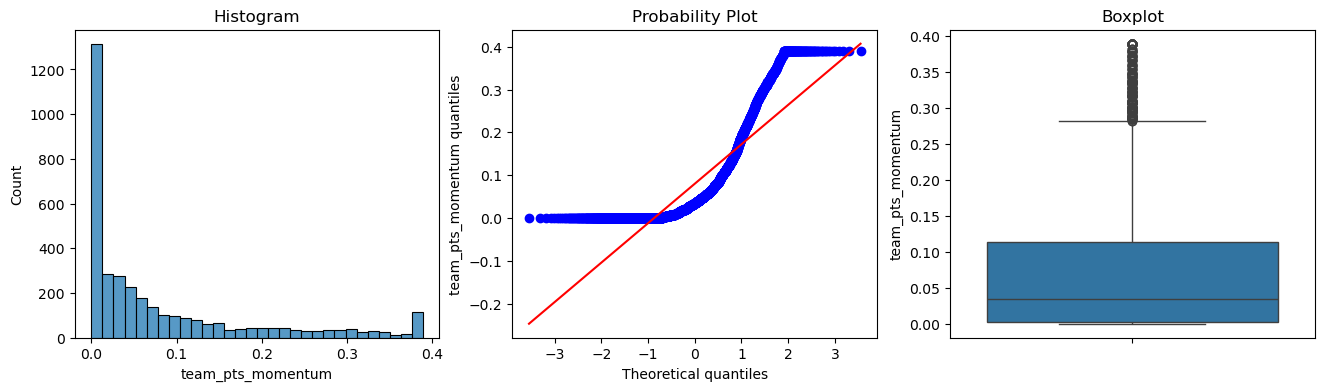

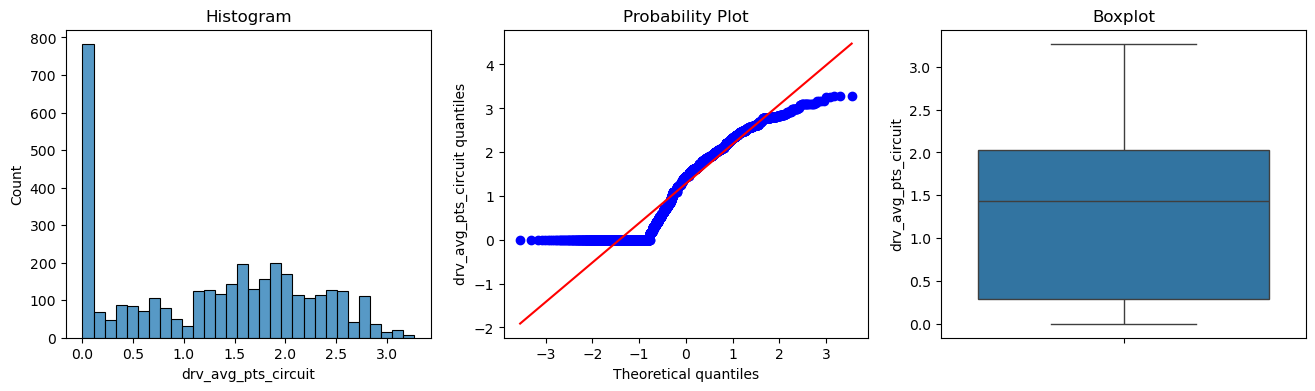

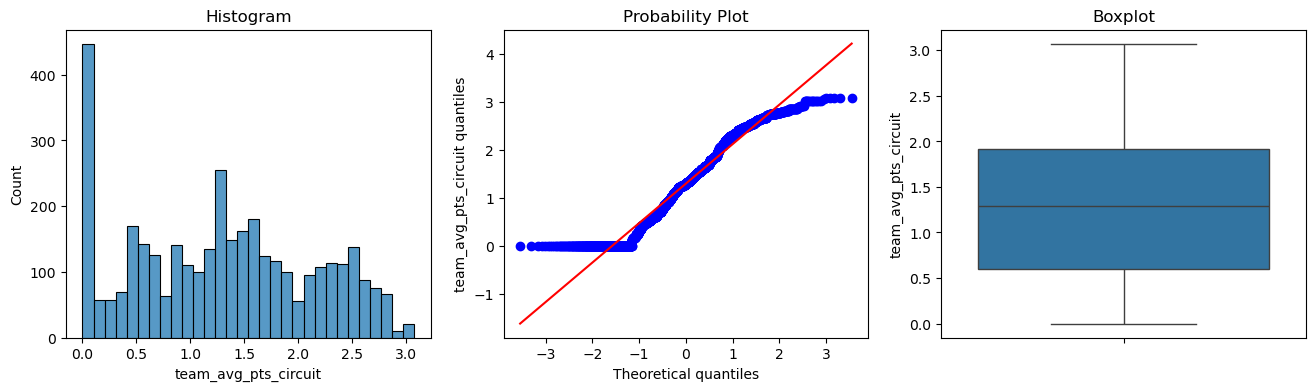

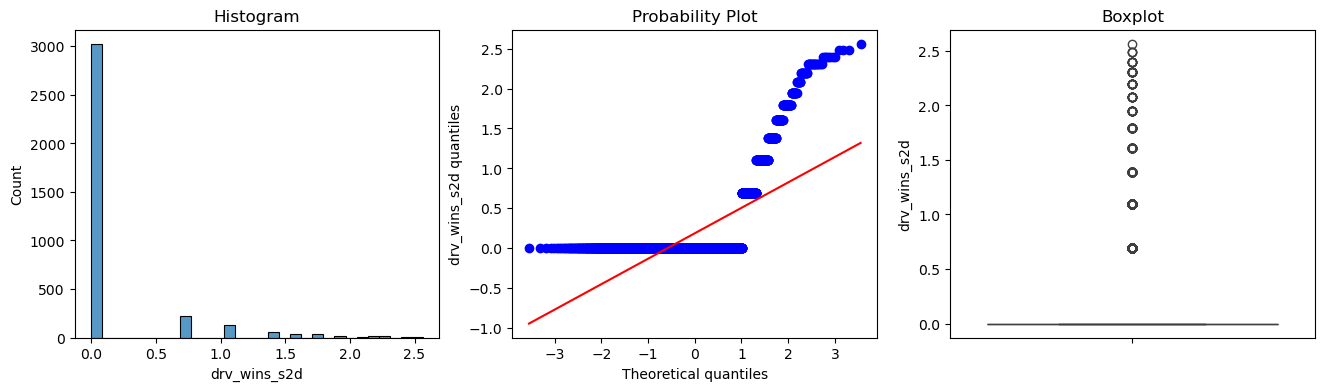

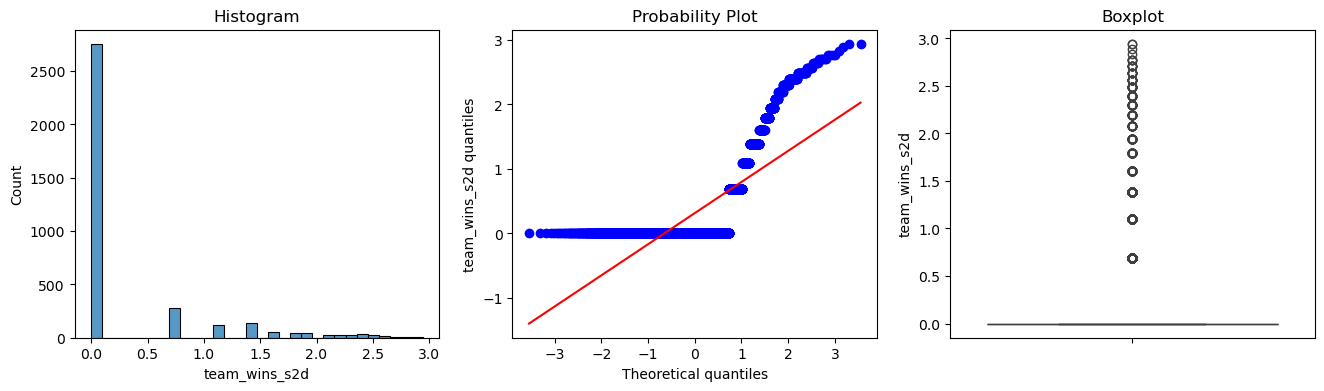

In [22]:
X_train = X_train_yjt.copy()
X_test = X_test_yjt.copy()
log_cols = [
    'drv_pts_s2d',
    'team_pts_s2d',
    'drv_pts_momentum',
    'team_pts_momentum',
    'drv_avg_pts_circuit',
    'team_avg_pts_circuit',
    'drv_wins_s2d',
    'team_wins_s2d'
]

# Apply log1p (log(x+1)) transformation
for col in log_cols:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])
    diagnostic_plots(X_train, col)

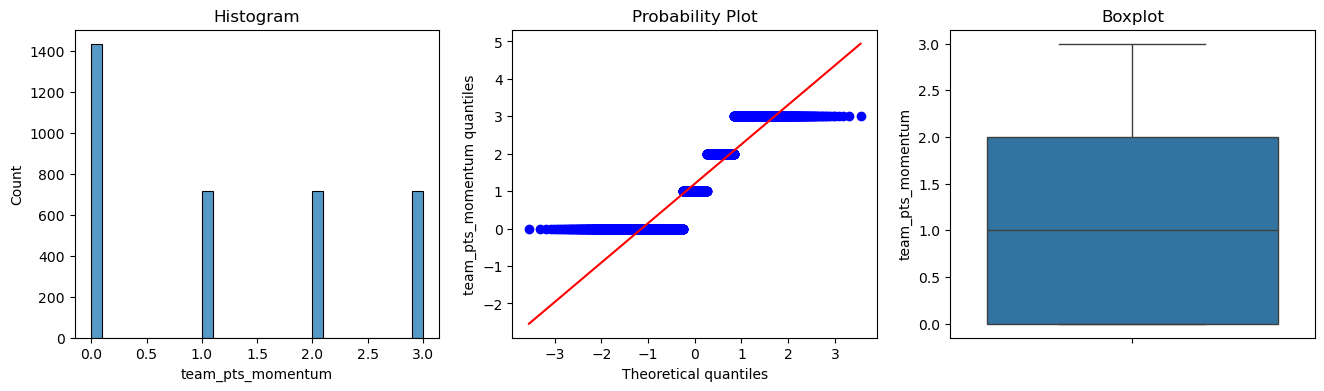

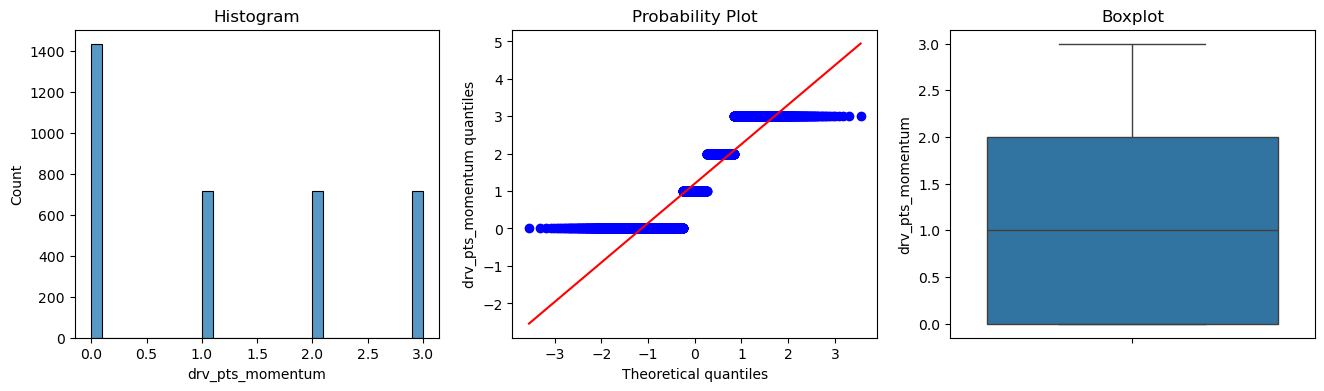

In [23]:
skewed = [
    'team_pts_momentum',
    'drv_pts_momentum',
]

for each in skewed:
    X_train[each] = pd.qcut(X_train[each], q=5, labels=False, duplicates='drop')
    diagnostic_plots(X_train, each)

for each in skewed:
     X_test[each]  = pd.qcut(X_test[each],  q=5, labels=False, duplicates='drop')

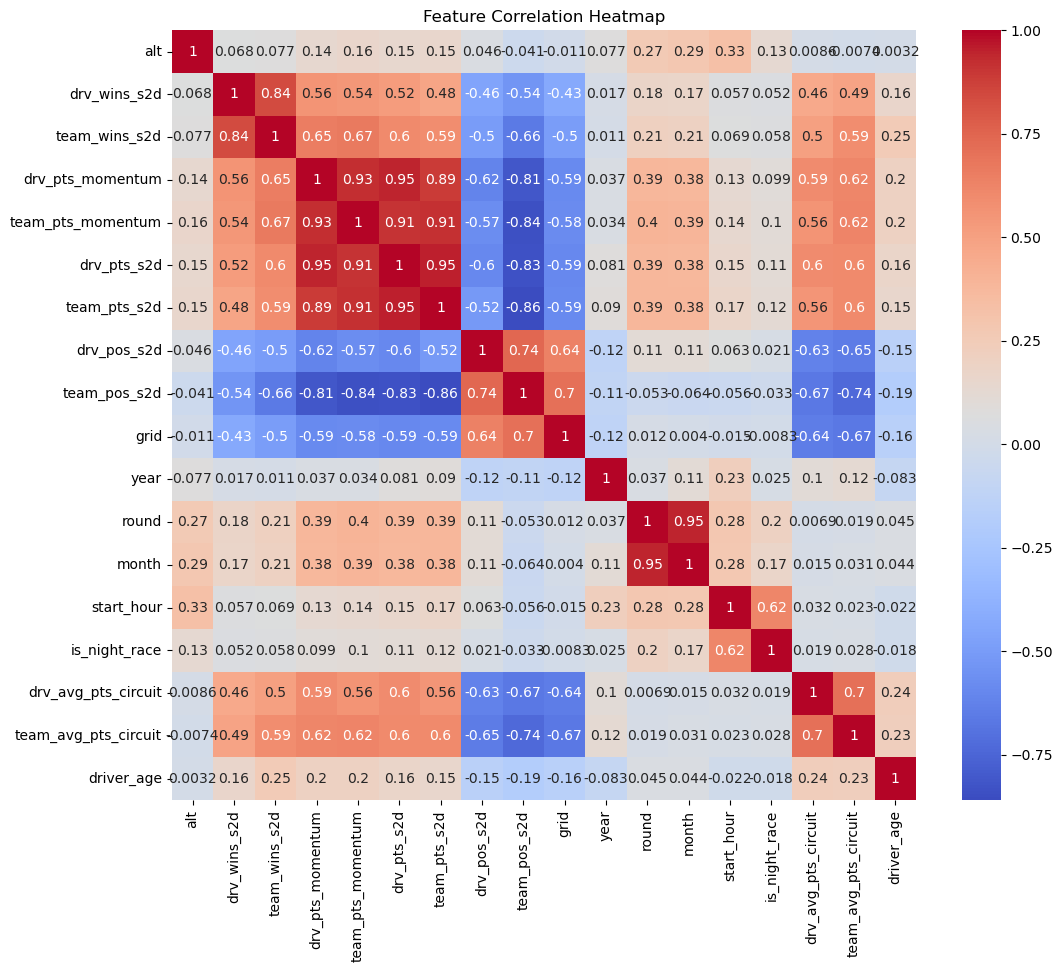

In [24]:
corr_matrix = X_train.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
cols_drop = [
    'team_wins_s2d',
    'team_pts_momentum',
    'team_pos_s2d',
    'month',
    'team_avg_pts_circuit',
    'drv_pts_s2d',
    'team_pts_s2d'
]

X_train_cleaned = X_train.drop(columns=cols_drop)
X_test_cleaned = X_test.drop(columns=cols_drop)

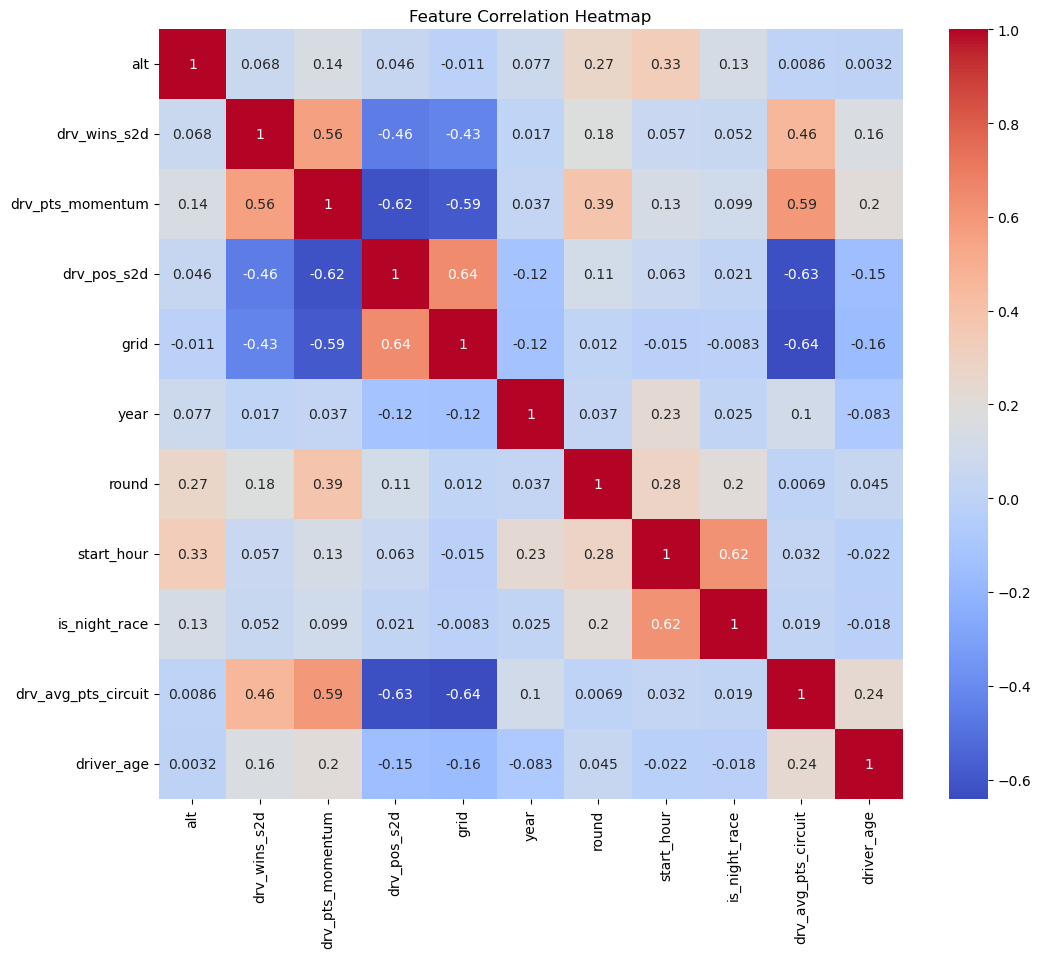

In [26]:
corr_matrix = X_train_cleaned.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

### Dealing with Categorical Columns

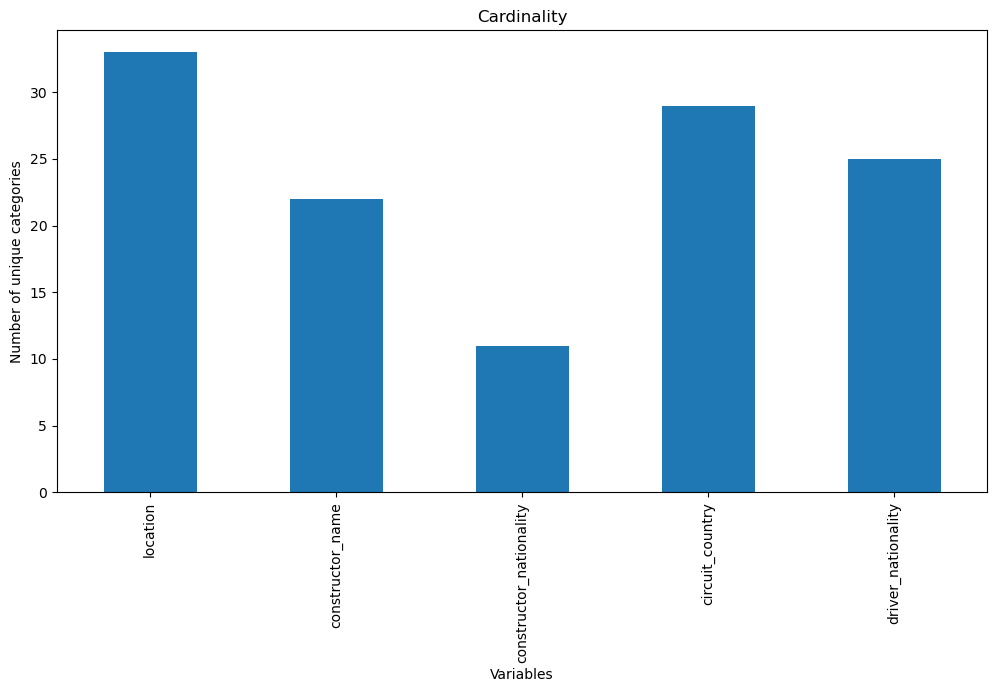

In [28]:
X_train = X_train_cleaned
X_test = X_test_cleaned
X_train[cat_cols].nunique().plot.bar(figsize=(12,6))

# add labels and title
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')
plt.show()

In [29]:
high_cardinality = ['constructor_name', 'location', 'driver_nationality', 'circuit_country']

mean_enc = MeanEncoder(variables=high_cardinality)
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['constructor_name', 'location', 'driver_nationality',
                       'circuit_country'])

In [30]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

In [31]:
# ohe_enc = OneHotEncoder(variables='constructor_nationality', top_categories=5,drop_last=False)
# ohe_enc.fit(X_train)

In [32]:
ohe_enc = OneHotEncoder(variables='constructor_nationality',drop_last=False)
ohe_enc.fit(X_train)

OneHotEncoder(variables='constructor_nationality')

In [33]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

In [34]:
num_cols = [c for c in X_train.columns if X_train[c].dtypes!='O']
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# set up the scaler
scaler = RobustScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

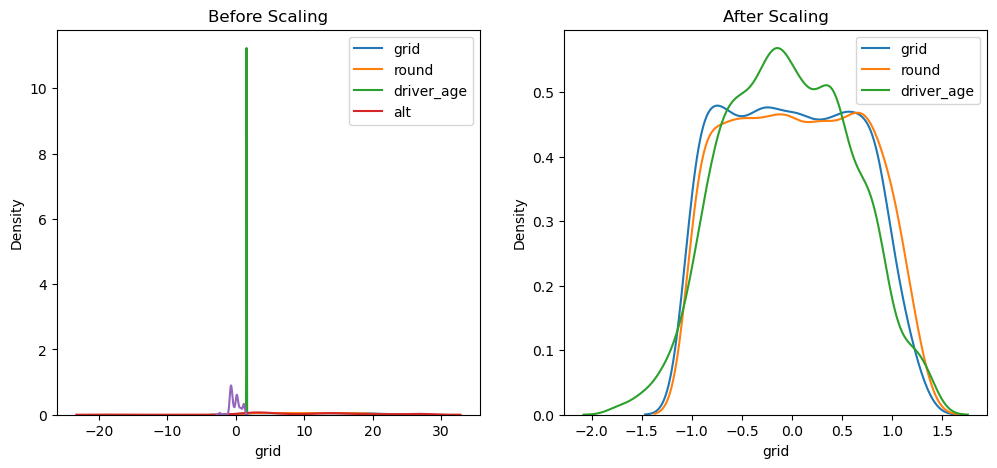

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['grid'], ax=ax1, label ='grid')
sns.kdeplot(X_train['round'], ax=ax1, label ='round')
sns.kdeplot(X_train['driver_age'], ax=ax1, label ='driver_age')
sns.kdeplot(X_train['alt'], ax=ax1, label ='alt')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['grid'], ax=ax2, label ='grid')
sns.kdeplot(X_train_scaled['round'], ax=ax2, label ='round')
sns.kdeplot(X_train_scaled['driver_age'], ax=ax2, label ='driver_age')
sns.kdeplot(X_train_scaled['alt'], ax=ax1, label ='alt')
ax2.legend()
plt.show()

## Building a naive & linear regression model

In [37]:
print(f"Size of X_train: {X_train_scaled.shape}")
print(f"Size of X_test: {X_test_scaled.shape}")

Size of X_train: (3580, 26)
Size of X_test: (896, 26)


In [38]:
from sklearn.metrics import r2_score
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

# Evaluate baseline
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = baseline_mse ** 0.5
baseline_r2 = r2_score(y_test, baseline_pred)

print("Naive Baseline Performance:")
print(f" MSE:  {baseline_mse:.4f}")
print(f" RMSE: {baseline_rmse:.4f}")
print(f" R2:   {baseline_r2:.4f}")

Naive Baseline Performance:
 MSE:  50.0379
 RMSE: 7.0738
 R2:   -0.0007


In [39]:
print(y_train.mean())

mean_target_value = y_train.mean()

print(f"The train mean target value is {mean_target_value:.2f}.")

y_train_preds_naive = [round(mean_target_value,2) for row in X_train_scaled.iloc[:,0]]
print(f"The first five score for train: {y_train_preds_naive[0:5]}")

y_test_preds_naive = [round(mean_target_value,2) for row in X_test_scaled.iloc[:,0]]
print(f"The first five score for test: {y_test_preds_naive[0:5]}")

4.824720670391062
The train mean target value is 4.82.
The first five score for train: [4.82, 4.82, 4.82, 4.82, 4.82]
The first five score for test: [4.82, 4.82, 4.82, 4.82, 4.82]


In [40]:
from sklearn.metrics import root_mean_squared_error
y_true = y_train
y_pred = y_train_preds_naive

train_mse_naive = mean_squared_error(y_true, y_pred)
print(f"The Naive Baseline Model's MSE on train data is {train_mse_naive:.2f}.")

# test MSE score
y_true = y_test
y_pred = y_test_preds_naive

test_mse_naive = mean_squared_error(y_true, y_pred)
print(f"The Naive Baseline Model's MSE on test data is {test_mse_naive:.2f}.")

print()

# Root Mean Squared Error (if MSE < 1, rooting it makes it numerically larger, vice-versa if MSE > 1)

# train RMSE score
y_true = y_train
y_pred = y_train_preds_naive

train_rmse_naive = root_mean_squared_error(y_true, y_pred)
print(f"The Naive Baseline Model's RMSE on train data is {train_rmse_naive:.2f}.")

# test RMSE score
y_true = y_test
y_pred = y_test_preds_naive

test_rmse_naive = root_mean_squared_error(y_true, y_pred)
print(f"The Naive Baseline Model's RMSE on test data is {test_rmse_naive:.2f}.")

print()

# R2 Value (Coefficient of Determination, which measures how well the X cols account for y's variance, 1.0 is best score)

# train R2 score
y_true = y_train
y_pred = y_train_preds_naive

train_r2_naive = r2_score(y_true, y_pred)
print(f"The Naive Baseline Model's R2 on train data is {train_r2_naive:.2f}.")

# test R2 score
y_true = y_test
y_pred = y_test_preds_naive

test_r2_naive = r2_score(y_true, y_pred)
print(f"The Naive Baseline Model's R2 on test data is {test_r2_naive:.2f}.")


The Naive Baseline Model's MSE on train data is 51.13.
The Naive Baseline Model's MSE on test data is 50.04.

The Naive Baseline Model's RMSE on train data is 7.15.
The Naive Baseline Model's RMSE on test data is 7.07.

The Naive Baseline Model's R2 on train data is -0.00.
The Naive Baseline Model's R2 on test data is -0.00.


In [41]:
from sklearn.linear_model import LinearRegression

linreg_ss = LinearRegression().fit(X_train_scaled, y_train)

y_train_preds_linreg_ss = linreg_ss.predict(X_train_scaled)
y_test_preds_linreg_ss = linreg_ss.predict(X_test_scaled)

In [42]:
# Mean Squared Error (the lower the better, 0 is best possible score)

# train MSE score
y_true = y_train
y_pred = y_train_preds_linreg_ss

train_mse_linreg_ss = mean_squared_error(y_true, y_pred)
print(f"The LinRegSS Model's MSE on train data is {train_mse_linreg_ss:.4f}.")

# test MSE score
y_true = y_test
y_pred = y_test_preds_linreg_ss

test_mse_linreg_ss = mean_squared_error(y_true, y_pred)
print(f"The LinRegSS Model's MSE on test data is {test_mse_linreg_ss:.4f}.")

print()

# Root Mean Squared Error (if MSE < 1, rooting it makes it numerically larger, vice-versa if MSE > 1)
# train RMSE score
y_true = y_train
y_pred = y_train_preds_linreg_ss

train_rmse_linreg_ss = root_mean_squared_error(y_true, y_pred)
print(f"The LinRegSS Model's RMSE on train data is {train_rmse_linreg_ss:.4f}.")

# test RMSE score
y_true = y_test
y_pred = y_test_preds_linreg_ss

test_rmse_linreg_ss = root_mean_squared_error(y_true, y_pred)
print(f"The LinRegSS Model's RMSE on test data is {test_rmse_linreg_ss:.4f}.")

print()



The LinRegSS Model's MSE on train data is 21.2096.
The LinRegSS Model's MSE on test data is 23.5734.

The LinRegSS Model's RMSE on train data is 4.6054.
The LinRegSS Model's RMSE on test data is 4.8552.



In [43]:

#train R2 score
y_true = y_train
y_pred = y_train_preds_linreg_ss

train_r2_linreg_ss = r2_score(y_true, y_pred)
print(f"The LinRegSS Model's R2 on train data is {train_r2_linreg_ss:.4f}.")

# test R2 score
y_true = y_test
y_pred = y_test_preds_linreg_ss

test_r2_linreg_ss = r2_score(y_true, y_pred)
print(f"The LinRegSS Model's R2 on test data is {test_r2_linreg_ss:.4f}.")

# R2 Value (Coefficient of Determination, which measures how well the X cols account for y's variance, 1.0 is best score)



The LinRegSS Model's R2 on train data is 0.5852.
The LinRegSS Model's R2 on test data is 0.5286.


In [44]:
linreg_ss_importance = linreg_ss.coef_
linreg_ss_importance

array([-0.05349422,  3.22795249, -0.43640978, -0.69616423, -2.96121395,
       -0.27285846, -0.09967676,  0.40470251,  0.01020654, -0.14785186,
        4.04769654, -0.23558134,  2.62066465, -0.14413108, -0.06703609,
       -0.55719304, -0.97273485, -0.27397165, -0.5985119 ,  2.18417846,
       -1.02792049, -1.10560318,  2.37455623, -0.27455544, -1.2446768 ,
        1.49643267])

In [45]:
df_linreg_ss_feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": linreg_ss_importance
})
df_linreg_ss_feature_importance


,feature,importance
0,alt,-0.053494
1,drv_wins_s2d,3.227952
2,drv_pts_momentum,-0.436410
3,drv_pos_s2d,-0.696164
4,grid,-2.961214
5,year,-0.272858
6,round,-0.099677
7,location,0.404703
8,start_hour,0.010207
9,is_night_race,-0.147852


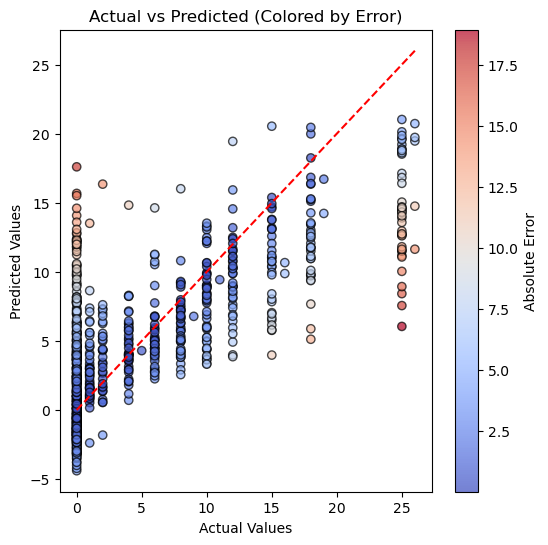

In [46]:
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(6,6))
scatter = plt.scatter(
    y_test,
    y_pred,
    c=errors,                # color based on error
    cmap='coolwarm',          # color map
    alpha=0.7,
    edgecolor='k'
)

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Colored by Error)")

# Colorbar to show error scale
cbar = plt.colorbar(scatter)
cbar.set_label("Absolute Error")

plt.show()

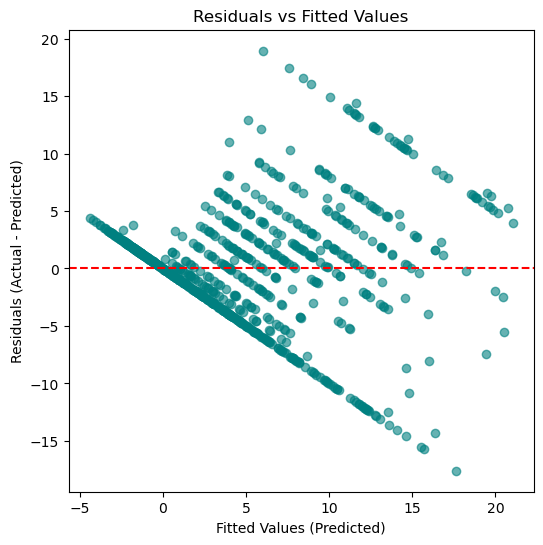

In [47]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals, alpha=0.6, color="teal")
plt.axhline(y=0, color="red", linestyle="--")  # zero error line
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Fitted Values")
plt.show()


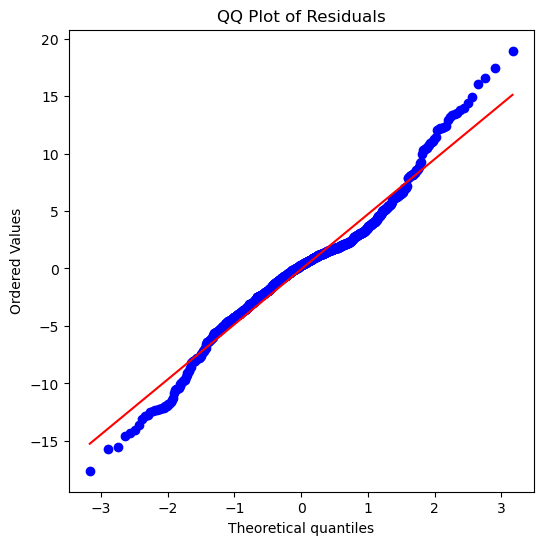

In [48]:
residuals = y_test - y_pred

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()